In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler
from itertools import combinations
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge


In [2]:
# Load a dataset
df = pd.read_csv('gorilla_tug_of_war.csv')

# Display first few rows
df.head()

,WHT,FRC,AGE,DSI,SUS,GND,HMNS
0,199.4,145,40,603,Western Lowland,Male,224
1,197.7,146,22,268,Western Lowland,Male,220
2,136.0,117,30,47,Western Lowland,Female,144
3,138.0,100,36,52,Western Lowland,Female,174
4,196.2,102,35,488,Mountain,Male,216


In [3]:
df.describe()

,WHT,FRC,AGE,DSI,HMNS
count,500.000000,500.000000,500.000000,500.000000,500.000000
mean,178.423200,112.752000,24.446000,211.622000,202.372000
std,43.545844,28.490242,9.391458,196.069706,29.509715
min,93.900000,37.000000,-4.000000,1.000000,88.000000
25%,150.800000,94.000000,16.000000,74.750000,188.750000
50%,175.050000,112.000000,25.000000,151.500000,212.000000
75%,202.625000,131.250000,32.000000,285.500000,223.000000
max,765.900000,203.000000,40.000000,1095.000000,249.000000


# Outliers

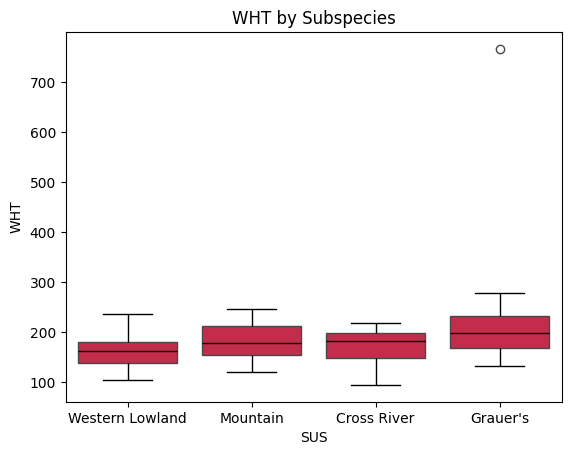

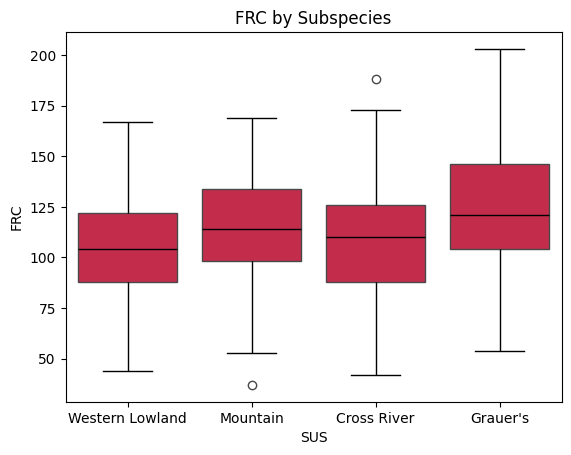

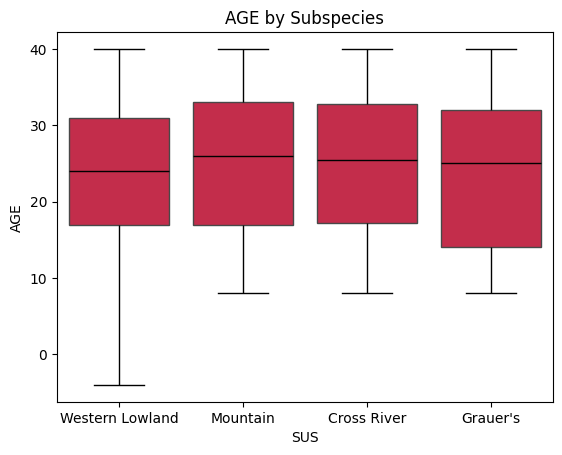

In [4]:
for i in ['WHT', 'FRC', 'AGE'] :
    sns.boxplot(data=df, x='SUS', y=i , color='crimson',
        whiskerprops=dict(color='black'),
        capprops=dict(color='black'),
        medianprops=dict(color='black')
               )
    plt.title(f'{i} by Subspecies')
    plt.show()

In [5]:
# Separate features and target variable:
X = df.drop(columns=['HMNS'])
y = df['HMNS']

In [6]:
# Separate features into numerical and categorical columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

In [7]:
# Split into train/test sets (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# Copies of original train and test sets
X_train_orig = X_train.copy()
X_test_orig = X_test.copy()

In [9]:
# Remove outliers
def remove_outliers_iqr(df, numerical_cols):
    df_filtered = df.copy()
    for col in numerical_cols:
        df_filtered[col] = df_filtered[col].astype(float)
        Q1 = df_filtered[col].quantile(0.25)
        Q3 = df_filtered[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_filtered = df_filtered[(df_filtered[col] >= lower_bound) & (df_filtered[col] <= upper_bound)]
    return df_filtered

X_train_filtered = remove_outliers_iqr(X_train, numerical_cols)
y_train_filtered = y_train.loc[X_train_filtered.index]

X_test_filtered = remove_outliers_iqr(X_test, numerical_cols)
y_test_filtered = y_test.loc[X_test_filtered.index]


In [10]:
# One-hot encoding
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

X_train_cat_filtered = X_train_filtered[categorical_cols]
X_train_encoded = pd.DataFrame(
    encoder.fit_transform(X_train_cat_filtered),
    columns=encoder.get_feature_names_out(categorical_cols),
    index=X_train_cat_filtered.index
)

X_test_cat_filtered = X_test_filtered[categorical_cols]
X_test_encoded = pd.DataFrame(
    encoder.transform(X_test_cat_filtered),
    columns=encoder.get_feature_names_out(categorical_cols),
    index=X_test_cat_filtered.index
)

X_train_final = pd.concat([X_train_filtered[numerical_cols], X_train_encoded], axis=1)
X_test_final = pd.concat([X_test_filtered[numerical_cols], X_test_encoded], axis=1)

X_train_final.head()

,WHT,FRC,AGE,DSI,SUS_Cross River,SUS_Grauer's,SUS_Mountain,SUS_Western Lowland,GND_Female,GND_Male
249,177.0,118.0,28.0,184.0,0.0,0.0,0.0,1.0,0.0,1.0
433,197.9,118.0,25.0,157.0,0.0,0.0,1.0,0.0,0.0,1.0
19,152.4,102.0,38.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
301,155.4,70.0,35.0,455.0,1.0,0.0,0.0,0.0,1.0,0.0
229,124.8,81.0,24.0,19.0,0.0,0.0,0.0,1.0,1.0,0.0


In [11]:
df_all = pd.concat([X_train_final,X_test_final])

df_all['HMNS'] = pd.concat([y_train_filtered,y_test_filtered])



df_all.head(3)

,WHT,FRC,AGE,DSI,SUS_Cross River,SUS_Grauer's,SUS_Mountain,SUS_Western Lowland,GND_Female,GND_Male,HMNS
249,177.0,118.0,28.0,184.0,0.0,0.0,0.0,1.0,0.0,1.0,200
433,197.9,118.0,25.0,157.0,0.0,0.0,1.0,0.0,0.0,1.0,234
19,152.4,102.0,38.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,199


# Random Forest Feature Importance

In our Random Forest regression model, we evaluate **feature importance** to understand which input variables have the most influence on the model's predictions.

We use the **Mean Decrease in Impurity (MDI)** method, which is computed during the training process:

- Each decision tree in the forest splits on features to reduce the **variance** (since we are doing regression).
- For each feature, we track how much it reduces the total variance (impurity) across all trees.
- The **importance score** for each feature is the **sum of these variance reductions**, averaged over all trees.

This gives us a relative ranking of feature importance, helping us identify which features contribute most to accurate predictions.

> Note: While MDI is efficient and built-in, it can be biased towards features with more unique values. If needed, we may use **permutation importance** as a more robust alternative.


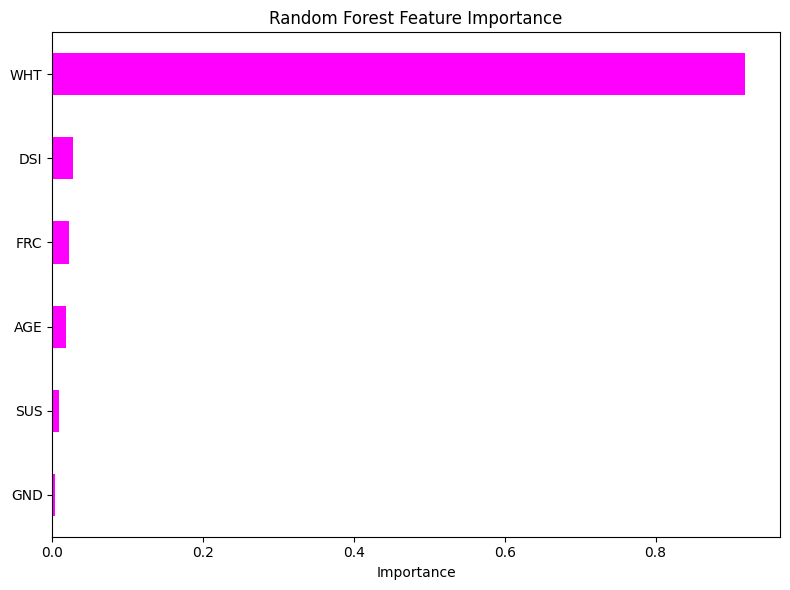

In [12]:
from sklearn.ensemble import RandomForestRegressor


df_encoded = df_all.copy()

# Define X and y
X = df_encoded.drop(columns=['HMNS'])
y = df_encoded['HMNS']  # Replace with your actual target variable

# Train the model
model = RandomForestRegressor(random_state=42)
model.fit(X, y)

# Get feature importances
importances = pd.Series(model.feature_importances_, index=X.columns)

# Aggregate SUS and GND importances
sus_cols = [col for col in X.columns if col.startswith('SUS_')]
gnd_cols = [col for col in X.columns if col.startswith('GND_')]

importances_combined = importances.drop(sus_cols + gnd_cols).copy()
importances_combined['SUS'] = importances[sus_cols].sum()
importances_combined['GND'] = importances[gnd_cols].sum()

# Sort for plotting
importances_combined = importances_combined.sort_values(ascending=False)

# Plot
plt.figure(figsize=(8, 6))
importances_combined.plot(kind='barh', color='magenta')
plt.title('Random Forest Feature Importance')
plt.xlabel('Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


# We recognize the significant weight of the 'WHT' feature. From this we can also look at how other features influence 'WHT'

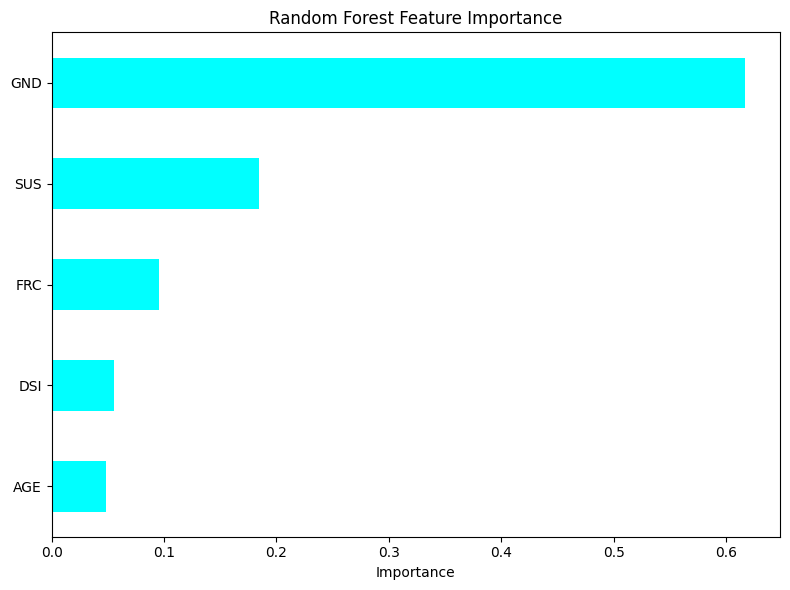

In [13]:



# Define X and y
X = df_encoded.drop(columns=['HMNS','WHT'])
y = df_encoded['WHT']  # Replace with your actual target variable

# Train the model
model = RandomForestRegressor(random_state=42)
model.fit(X, y)

# Get feature importances
importances = pd.Series(model.feature_importances_, index=X.columns)

# Aggregate SUS and GND importances
sus_cols = [col for col in X.columns if col.startswith('SUS_')]
gnd_cols = [col for col in X.columns if col.startswith('GND_')]

importances_combined = importances.drop(sus_cols + gnd_cols).copy()
importances_combined['SUS'] = importances[sus_cols].sum()
importances_combined['GND'] = importances[gnd_cols].sum()

# Sort for plotting
importances_combined = importances_combined.sort_values(ascending=False)

# Plot
plt.figure(figsize=(8, 6))
importances_combined.plot(kind='barh', color='cyan')
plt.title('Random Forest Feature Importance')
plt.xlabel('Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


# Correlation Matrix

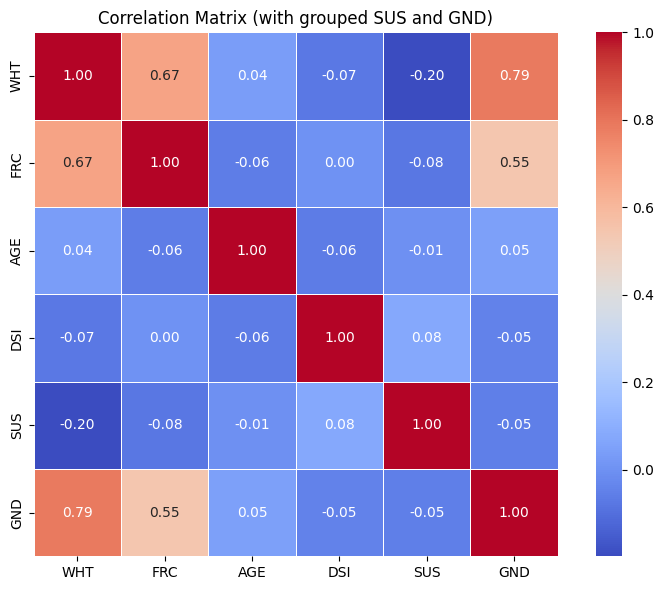

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create a copy to work on
df_corr = df_encoded.copy()

# Reconstruct SUS and GND from one-hot into single categorical codes
df_corr['SUS'] = df_encoded[[col for col in df_encoded.columns if col.startswith('SUS_')]].idxmax(axis=1)
df_corr['GND'] = df_encoded[[col for col in df_encoded.columns if col.startswith('GND_')]].idxmax(axis=1)

# Convert from column names to category labels (e.g., 'SUS_Cross River' -> 'Cross River')
df_corr['SUS'] = df_corr['SUS'].str.replace('SUS_', '')
df_corr['GND'] = df_corr['GND'].str.replace('GND_', '')

# Convert to numeric codes for correlation
df_corr['SUS'] = df_corr['SUS'].astype('category').cat.codes
df_corr['GND'] = df_corr['GND'].astype('category').cat.codes

# Drop original one-hot columns and 'HMNS'
df_corr = df_corr.drop(columns=[col for col in df_corr.columns if col.startswith(('SUS_', 'GND_', 'HMNS'))])

# Compute correlation matrix
corr_matrix = df_corr.corr(method='pearson')

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt=".2f", square=True, linewidths=0.5)
plt.title('Correlation Matrix (with grouped SUS and GND)')
plt.tight_layout()
plt.show()


### Relationship Between DSI, Age, and Weight

We initially expected a correlation between **DSI** (Days Since Illness) and **weight**, under the assumption that recent illness would reduce appetite and lead to muscle atrophy. Similarly, we anticipated a strong correlation between **age** and **weight**, as infants naturally weigh less than adults.

Additionally, we expected some correlation between **DSI** and **age**, assuming that older juveniles and early adults would be generally healthier, with fewer recent illnesses.

However, the plot below show that these relationships are weak or nonexistent. As a result, both **DSI** and **age** can reasonably be dropped as predictive features in our model.


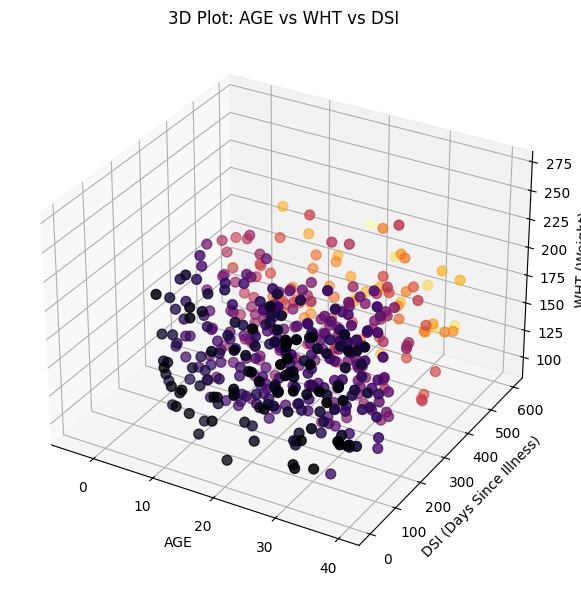

In [15]:
from mpl_toolkits.mplot3d import Axes3D

# Set up the 3D plot
fig = plt.figure(figsize=(10, 6))

ax = fig.add_subplot(111, projection='3d')

# Scatter plot
ax.scatter(df_encoded['AGE'],  df_encoded['DSI'], df_encoded['WHT'], c=df_encoded['DSI'], cmap='inferno', s=50)

# Axis labels
ax.set_xlabel('AGE')
ax.set_zlabel('WHT (Weight)')
ax.set_ylabel('DSI (Days Since Illness)')

plt.title('3D Plot: AGE vs WHT vs DSI')
plt.tight_layout()
plt.show()


## Decoding for hues and styling

In [16]:

# For SUS:find the column name with 1 in each row, then strip prefix
sus_columns = [col for col in df_encoded.columns if col.startswith('SUS_')]
df_encoded['SUS'] = df_encoded[sus_columns].idxmax(axis=1).str.replace('SUS_', '')

# For GND: same logic
gnd_columns = [col for col in df_encoded.columns if col.startswith('GND_')]
df_encoded['GND'] = df_encoded[gnd_columns].idxmax(axis=1).str.replace('GND_', '')


# HMNS vs WHT colored by Gender

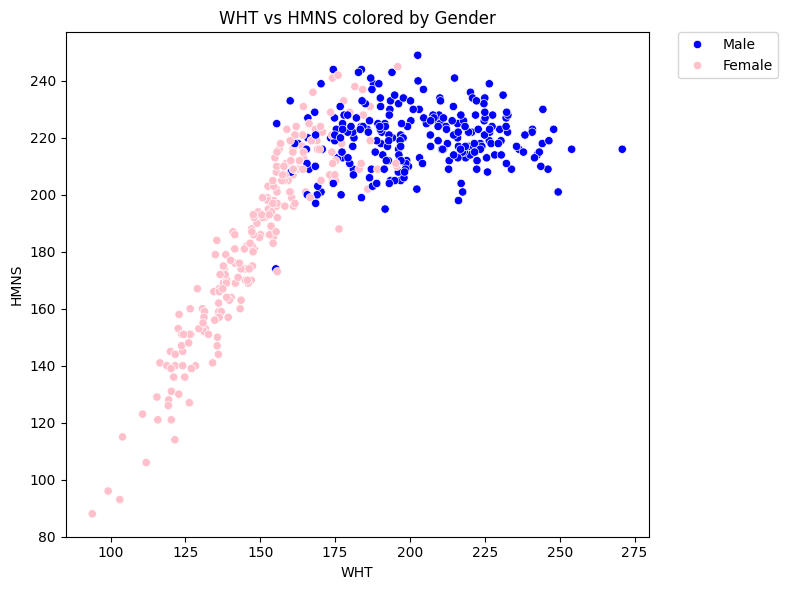

In [17]:



plt.figure(figsize=(8, 6))

# Define your color palette
custom_palette2 = {
    'Male': 'blue',
    'Female': 'pink'
}




sns.scatterplot(data=df_encoded, x='WHT', y='HMNS', hue='GND' , palette=custom_palette2 )

plt.title('WHT vs HMNS colored by Gender')

# Move legend to the right outside the plot
plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.tight_layout()
plt.show()


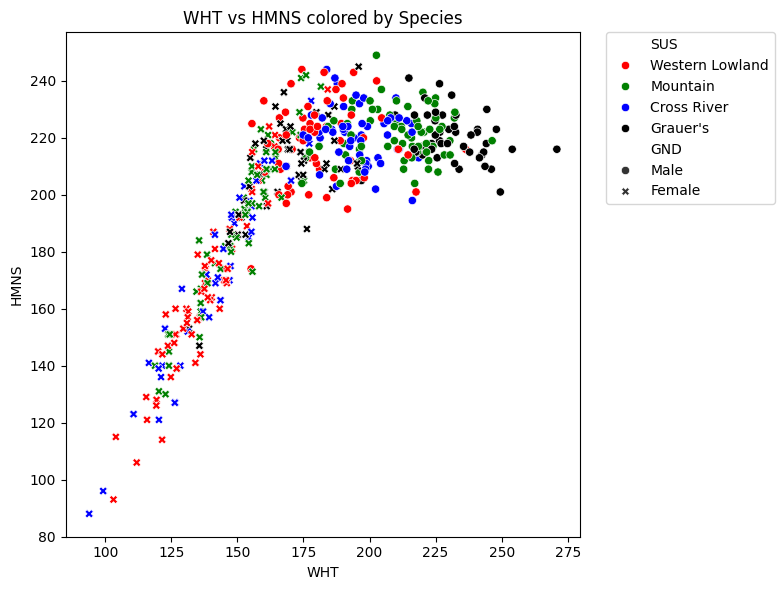

In [18]:


plt.figure(figsize=(8, 6))
custom_palette = {
    'Western Lowland': 'red',
    'Mountain': 'green',
    'Cross River': 'blue',
    "Grauer's": 'black'
}



sns.scatterplot(data=df_encoded, x='WHT', y='HMNS', hue='SUS' , style='GND'  ,palette=custom_palette)

plt.title('WHT vs HMNS colored by Species')

# Move legend to the right outside the plot
plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.tight_layout()
plt.show()


# HMNS vs FRC colored by Gender

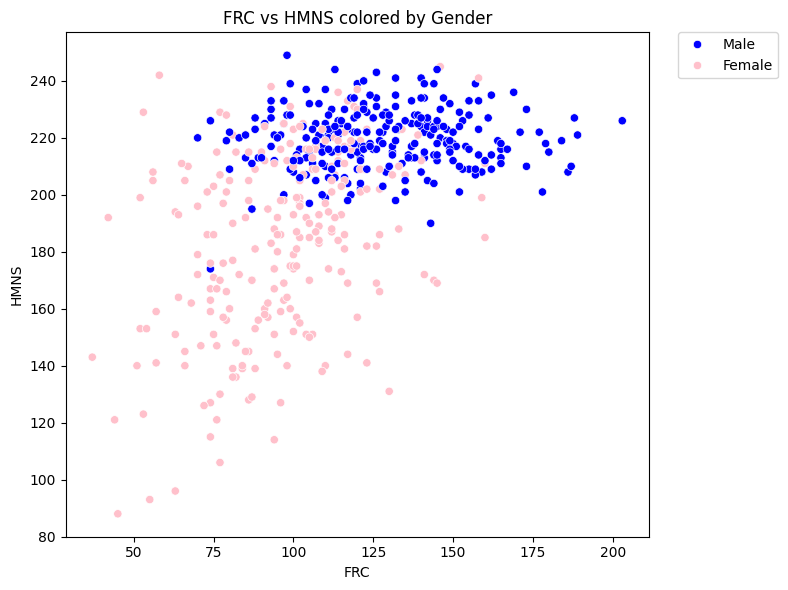

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

# Define your color palette
custom_palette2 = {
    'Male': 'blue',
    'Female': 'pink'
}


sns.scatterplot(data=df, x='FRC', y='HMNS', hue='GND' , palette=custom_palette2 )

plt.title('FRC vs HMNS colored by Gender')

# Move legend to the right outside the plot
plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.tight_layout()
plt.show()



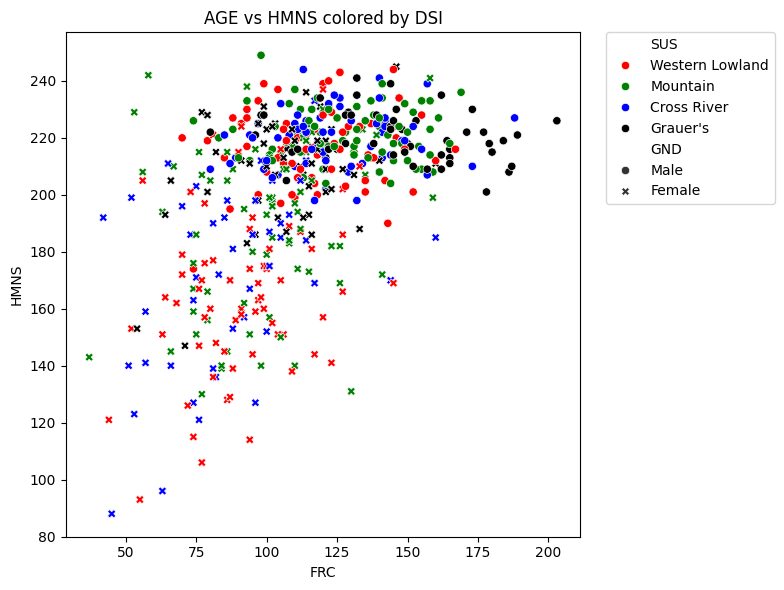

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))




sns.scatterplot(data=df[df['WHT']<700], x='FRC', y='HMNS', hue='SUS' , style='GND'  ,palette=custom_palette)

plt.title('AGE vs HMNS colored by DSI')

# Move legend to the right outside the plot
plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.tight_layout()
plt.show()


## Clear and visble Clusters between Male and Females are observed, now taking a look at the differences

In [21]:
df_m = df_encoded[ (df_encoded['GND']=='Male' ) ] #males

df_f = df_encoded[ (df_encoded['GND']=='Female') ] #females

# Males

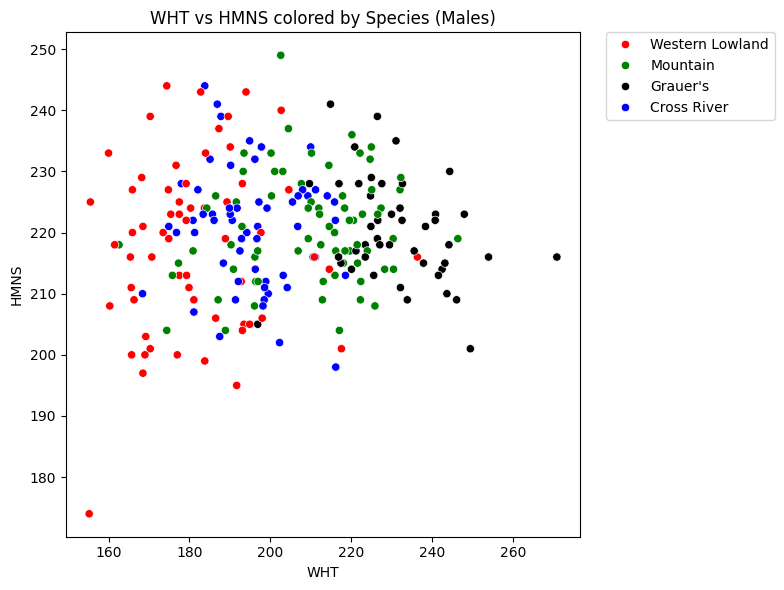

In [22]:


plt.figure(figsize=(8, 6))




sns.scatterplot(data=df_m , x='WHT', y='HMNS', hue='SUS'   ,palette=custom_palette)

plt.title('WHT vs HMNS colored by Species (Males)')

# Move legend to the right outside the plot
plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.tight_layout()
plt.show()


# Females

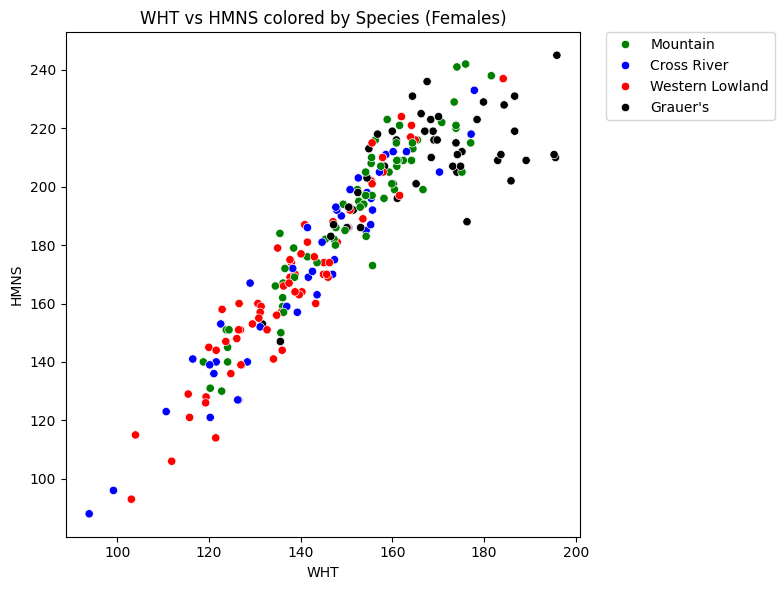

In [23]:

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
custom_palette = {
    'Western Lowland': 'red',
    'Mountain': 'green',
    'Cross River': 'blue',
    "Grauer's": 'black'
}



sns.scatterplot(data=df_f , x='WHT', y='HMNS', hue='SUS'   ,palette=custom_palette)

plt.title('WHT vs HMNS colored by Species (Females)')

# Move legend to the right outside the plot
plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.tight_layout()
plt.show()


<h1 style="color:red;">Linear Regression</h1>


In [24]:
# Model evaluation function for Linear Regression
def evaluate_linear_regression(X_train, y_train, X_test, y_test):
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"MSE: {mse:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f} | R²: {r2:.4f}")

In [25]:
evaluate_linear_regression(X_train_final, y_train_filtered, X_test_final, y_test_filtered)

MSE: 339.4165 | RMSE: 18.4233 | MAE: 15.5927 | R²: 0.4647


In [26]:
# Yeo-Johnson power transformation to reduce skewness
skewed_feats = X_train_final[numerical_cols].apply(lambda x: x.skew()).sort_values(ascending=False)
high_skew = skewed_feats[abs(skewed_feats) > 0.5].index.tolist()

X_train_before_transform = X_train_final.copy()
X_test_before_transform = X_test_final.copy()

if len(high_skew) > 0:
    pt = PowerTransformer(method='yeo-johnson')
    X_train_final[high_skew] = pt.fit_transform(X_train_final[high_skew])
    X_test_final[high_skew] = pt.transform(X_test_final[high_skew])

    # palette = sns.color_palette("tab10", 2) 
    # num_cols = len(high_skew)
    # cols_per_row = 3
    # rows = (num_cols + cols_per_row - 1) // cols_per_row

    # fig, axes = plt.subplots(rows, cols_per_row, figsize=(6 * cols_per_row, 5 * rows))
    # axes = axes.flatten()

    # for i, col in enumerate(high_skew):
    #     sns.kdeplot(
    #         data=X_train_before_transform, x=col, fill=True, color=palette[1], alpha=0.3, label='Before (Capped)', ax=axes[i]
    #     )
    #     sns.kdeplot(
    #         data=X_train_final, x=col, fill=True, color=palette[0], alpha=0.7, label='After (Yeo-Johnson)', ax=axes[i]
    #     )
    #     axes[i].set_title(f'KDE for {col} (Before vs After)')
    #     axes[i].legend()

    # for j in range(i + 1, len(axes)):
    #     axes[j].set_visible(False)

    # plt.tight_layout()
    # plt.show()

else:
    print("No highly skewed numerical features found to transform.")


In [27]:
evaluate_linear_regression(X_train_final, y_train_filtered, X_test_final, y_test_filtered)

MSE: 343.7021 | RMSE: 18.5392 | MAE: 15.6946 | R²: 0.4579


In [28]:
# Scaling 
scaler = MinMaxScaler()
X_train_final[numerical_cols] = scaler.fit_transform(X_train_final[numerical_cols])
X_test_final[numerical_cols] = scaler.transform(X_test_final[numerical_cols])


In [29]:
evaluate_linear_regression(X_train_final, y_train_filtered, X_test_final, y_test_filtered)

MSE: 343.7021 | RMSE: 18.5392 | MAE: 15.6946 | R²: 0.4579


In [30]:
# Polynomial features or interaction terms can capture nonlinear relationships
poly_dict = {}
X_train_num = X_train[numerical_cols].copy()

for feature in numerical_cols:
    for p in range(2, 5):
        X_train_poly = X_train_num.copy()
        new_col_name = f"{feature}_pow_{p}"
        X_train_poly[new_col_name] = X_train_poly[feature] ** p

        lr = LinearRegression()
        lr.fit(X_train_poly, y_train)
        score = lr.score(X_train_poly, y_train) 

        poly_dict[score] = [feature, p]

best_score = max(poly_dict.keys())
best_feature, best_power = poly_dict[best_score]
print(f"Best polynomial feature: {best_feature}^{best_power} with R² score {best_score:.4f}")

poly_col_name = f"{best_feature}_pow_{best_power}"
X_train[poly_col_name] = X_train[best_feature] ** best_power
X_test[poly_col_name] = X_test[best_feature] ** best_power


Best polynomial feature: WHT^2 with R² score 0.6349


In [31]:
evaluate_linear_regression(X_train_final, y_train_filtered, X_test_final, y_test_filtered)

MSE: 343.7021 | RMSE: 18.5392 | MAE: 15.6946 | R²: 0.4579


In [32]:
# Feature interactions
interaction_dict = {}
columns_list = X_train_final.columns.tolist() 

for feat1, feat2 in combinations(columns_list, 2):
    X_train_int = X_train_final.copy()
    new_col_name = f"{feat1}_x_{feat2}"

    X_train_int[new_col_name] = X_train_int[feat1] * X_train_int[feat2]

    model = LinearRegression()
    model.fit(X_train_int, y_train_filtered)

    y_pred = model.predict(X_train_int)
    r2 = r2_score(y_train_filtered, y_pred)

    interaction_dict[r2] = (feat1, feat2)

top_5_r2 = sorted(interaction_dict.keys(), reverse=True)[:5]

for r2 in top_5_r2:
    feat1, feat2 = interaction_dict[r2]
    col_name = f"{feat1}_x_{feat2}"
    
    X_train_final[col_name] = X_train_final[feat1] * X_train_final[feat2]
    X_test_final[col_name] = X_test_final[feat1] * X_test_final[feat2]

    print(f"Added interaction: {col_name} with R²: {r2:.4f}")

Added interaction: WHT_x_GND_Male with R²: 0.8678
Added interaction: WHT_x_GND_Female with R²: 0.8678
Added interaction: WHT_x_FRC with R²: 0.7457
Added interaction: WHT_x_SUS_Grauer's with R²: 0.6816
Added interaction: SUS_Grauer's_x_GND_Male with R²: 0.6760


In [33]:
evaluate_linear_regression(X_train_final, y_train_filtered, X_test_final, y_test_filtered)

MSE: 111.9190 | RMSE: 10.5792 | MAE: 8.4070 | R²: 0.8235


In [34]:
# Feature selection 
y_train_num = y_train_filtered.astype(float)
y_test_num = y_test_filtered.astype(float)

ridge_cv = RidgeCV(alphas=[0.01, 0.1, 1.0, 10.0, 100.0], cv=5)
lasso_cv = LassoCV(alphas=[0.01, 0.1, 1.0, 10.0], cv=5, max_iter=10000)

ridge_cv.fit(X_train_final, y_train_num)
lasso_cv.fit(X_train_final, y_train_num)

ridge_preds = ridge_cv.predict(X_test_final)
lasso_preds = lasso_cv.predict(X_test_final)

print(f"Best Ridge alpha: {ridge_cv.alpha_}")
print("Ridge Regression R2:", r2_score(y_test_num, ridge_preds))
print("Ridge Regression MSE:", mean_squared_error(y_test_num, ridge_preds))

print(f"\nBest Lasso alpha: {lasso_cv.alpha_}")
print("Lasso Regression R2:", r2_score(y_test_num, lasso_preds))
print("Lasso Regression MSE:", mean_squared_error(y_test_num, lasso_preds))

ridge_coefs = pd.Series(ridge_cv.coef_, index=X_train_final.columns).sort_values(key=abs, ascending=False)
lasso_coefs = pd.Series(lasso_cv.coef_, index=X_train_final.columns).sort_values(key=abs, ascending=False)

selected_features = lasso_coefs[lasso_coefs != 0].index.tolist()
print(f"Selected features from Lasso: {selected_features}")

Best Ridge alpha: 0.01
Ridge Regression R2: 0.8227175371004833
Ridge Regression MSE: 112.40905199029885

Best Lasso alpha: 0.01
Lasso Regression R2: 0.8209145298787628
Lasso Regression MSE: 113.55228031198651
Selected features from Lasso: ['WHT_x_GND_Female', 'GND_Female', "WHT_x_SUS_Grauer's", 'WHT', "SUS_Grauer's_x_GND_Male", 'WHT_x_FRC', "SUS_Grauer's", 'FRC', 'DSI', 'SUS_Western Lowland', 'AGE', 'SUS_Cross River', 'SUS_Mountain', 'GND_Male']


In [35]:
X_train_selected = X_train_final[selected_features]
X_test_selected = X_test_final[selected_features]

In [36]:
final_model = LinearRegression()
final_model.fit(X_train_selected, y_train_num)

y_pred = final_model.predict(X_test_selected)

# Evaluation metrics for regression
mse = mean_squared_error(y_test_num, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_num, y_pred)
r2 = r2_score(y_test_num, y_pred)

print(f"Final Model - MSE: {mse:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f} | R²: {r2:.4f}")

Final Model - MSE: 111.9190 | RMSE: 10.5792 | MAE: 8.4070 | R²: 0.8235


#### Hyperparameter Tuning 

In [37]:
# Grid search
param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 20, 50, 100, 200],
    'fit_intercept': [True, False],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'saga'],
    'tol': [1e-4, 1e-3, 1e-2],
    'max_iter': [1000, 3000, 5000, 10000]
}


ridge = Ridge()
grid_search = GridSearchCV(
    estimator=ridge,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train_selected, y_train_num)

print("Best negative MSE: {:.4f}".format(grid_search.best_score_))
print("Best parameters:", grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_selected)

mse = mean_squared_error(y_test_num, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_num, y_pred)
r2 = r2_score(y_test_num, y_pred)

print(f"Test Set - MSE: {mse:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f} | R²: {r2:.4f}")

Fitting 5 folds for each of 1080 candidates, totalling 5400 fits
[CV] END alpha=0.001, fit_intercept=True, max_iter=1000, solver=auto, tol=0.0001; total time=   0.0s
[CV] END alpha=0.001, fit_intercept=True, max_iter=1000, solver=auto, tol=0.0001; total time=   0.0s
[CV] END alpha=0.001, fit_intercept=True, max_iter=1000, solver=auto, tol=0.0001; total time=   0.0s
[CV] END alpha=0.001, fit_intercept=True, max_iter=1000, solver=auto, tol=0.0001; total time=   0.0s
[CV] END alpha=0.001, fit_intercept=True, max_iter=1000, solver=auto, tol=0.001; total time=   0.0s
[CV] END alpha=0.001, fit_intercept=True, max_iter=1000, solver=auto, tol=0.0001; total time=   0.0s
[CV] END alpha=0.001, fit_intercept=True, max_iter=1000, solver=auto, tol=0.001; total time=   0.0s
[CV] END alpha=0.001, fit_intercept=True, max_iter=1000, solver=auto, tol=0.01; total time=   0.0s
[CV] END alpha=0.001, fit_intercept=True, max_iter=1000, solver=auto, tol=0.01; total time=   0.0s
[CV] END alpha=0.001, fit_interc

In [38]:
X_train_final

,WHT,FRC,AGE,DSI,SUS_Cross River,SUS_Grauer's,SUS_Mountain,SUS_Western Lowland,GND_Female,GND_Male,WHT_x_GND_Male,WHT_x_GND_Female,WHT_x_FRC,WHT_x_SUS_Grauer's,SUS_Grauer's_x_GND_Male
249,0.469492,0.554745,0.62500,0.603861,0.0,0.0,0.0,1.0,0.0,1.0,0.469492,0.000000,0.260448,0.000000,0.0
433,0.587571,0.554745,0.53125,0.559699,0.0,0.0,1.0,0.0,0.0,1.0,0.587571,0.000000,0.325952,0.000000,0.0
19,0.330508,0.437956,0.93750,0.000000,0.0,0.0,1.0,0.0,1.0,0.0,0.000000,0.330508,0.144748,0.000000,0.0
301,0.347458,0.204380,0.84375,0.917708,1.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.347458,0.071013,0.000000,0.0
229,0.174576,0.284672,0.50000,0.178398,0.0,0.0,0.0,1.0,1.0,0.0,0.000000,0.174576,0.049697,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,0.416384,0.525547,0.68750,0.900218,0.0,1.0,0.0,0.0,1.0,0.0,0.000000,0.416384,0.218830,0.416384,0.0
106,0.148588,0.284672,0.71875,0.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.148588,0.042299,0.000000,0.0
348,0.725424,0.810219,0.50000,0.468283,0.0,0.0,1.0,0.0,0.0,1.0,0.725424,0.000000,0.587752,0.000000,0.0
435,0.172316,0.379562,0.28125,0.508814,0.0,0.0,1.0,0.0,1.0,0.0,0.000000,0.172316,0.065405,0.000000,0.0
